In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
for n_cell in range(2, 8):
    for relative_density in np.arange(0.05, 0.55, 0.05):
        t_over_l = np.sqrt(3)/2 - np.sqrt(3 - 4*relative_density)/2
        cell_size = design_height/(np.sqrt(3)*n_cell + t_over_l)
        wall_thickness = cell_size*t_over_l

        external_wall = True
        external_wall_thickness = wall_thickness
        if wall_thickness*1000 < 0.8:
            continue
        print(f"Cell Count: {n_cell}\tRho: {relative_density:1.2f}\tWall thickness: {wall_thickness*1000:1.3f}")

Cell Count: 3	Rho: 0.30	Wall thickness: 0.905
Cell Count: 3	Rho: 0.35	Wall thickness: 1.075
Cell Count: 3	Rho: 0.40	Wall thickness: 1.254
Cell Count: 3	Rho: 0.45	Wall thickness: 1.443
Cell Count: 3	Rho: 0.50	Wall thickness: 1.645
Cell Count: 4	Rho: 0.35	Wall thickness: 0.815
Cell Count: 4	Rho: 0.40	Wall thickness: 0.952
Cell Count: 4	Rho: 0.45	Wall thickness: 1.098
Cell Count: 4	Rho: 0.50	Wall thickness: 1.255
Cell Count: 5	Rho: 0.45	Wall thickness: 0.886
Cell Count: 5	Rho: 0.50	Wall thickness: 1.014
Cell Count: 6	Rho: 0.50	Wall thickness: 0.851


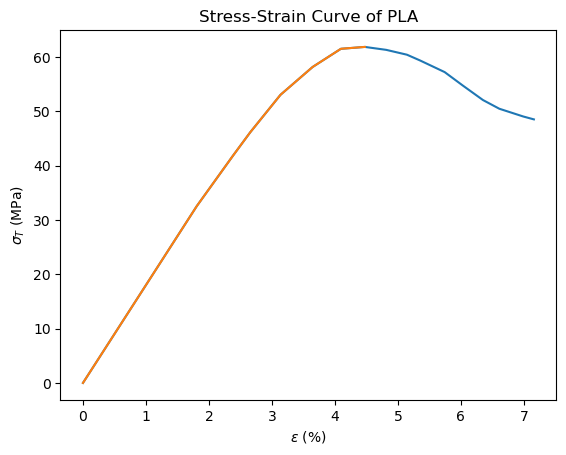

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

stress_strain = pd.read_excel('PLA stress-strain.xlsx')
plt.plot(stress_strain['x'], stress_strain['y (MPa)'])
plt.xlabel('$\epsilon$ (%)')
plt.ylabel('$\sigma_T$ (MPa)')
plt.title("Stress-Strain Curve of PLA")

stress_strain = stress_strain.iloc[:8]
plt.plot(stress_strain['x'], stress_strain['y (MPa)'])

In [20]:
from ansys.mapdl import reader as pymapdl_reader
result = pymapdl_reader.read_binary(f"result/kagome/res_2d_0_30.rst")

In [21]:
import pyvista as pv
# 기본적으로 plot이 안돼서 html로 plot하도록 만듦
pv.set_jupyter_backend('html')
pv.start_xvfb()

In [22]:
result.plot_principal_nodal_stress(
    0,
    "SEQV",
    cpos="xy",
    background="w",
    text_color="k",
    add_text=True,
    show_edges=True,
)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

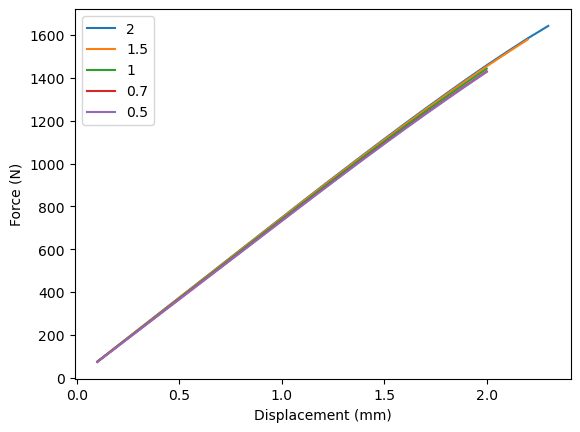

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
for mesh_size in [2, 1.5, 1, 0.7, 0.5, 0.3]:
    try:
        df = pd.read_csv(f"result/kagome/stress_strain_{mesh_size:1.2f}".replace(".", "_")+".csv")
        plt.plot(df['displacement']*1000, df['force'], label = mesh_size)
    except:
        pass
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

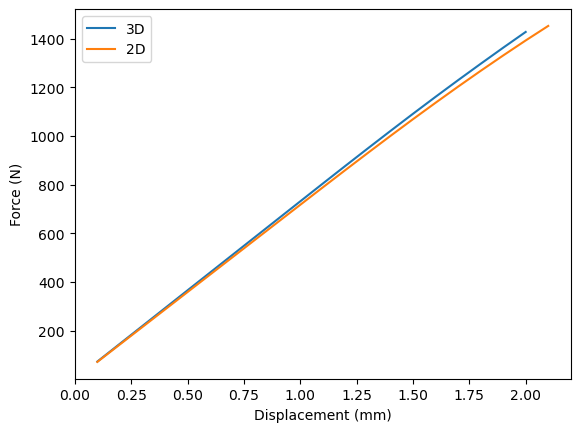

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(f"result/kagome/stress_strain_0_50.csv")
plt.plot(df['displacement']*1000, df['force'], label = "3D")

df = pd.read_csv(f"result/kagome/stress_strain_2d_0_30.csv")
plt.plot(df['displacement']*1000, df['force'], label = "2D")


plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

In [15]:
plt.plot(df['displacement'], df['force'], label = mesh_size)

AttributeError: module 'matplotlib' has no attribute 'plot'